# **Distance Predictor Part 5**
Author: Declan Costello

Date: 8/19/2023

## **Part 5 Description**

Here I Create pipelines with hyperparameter tuning Imputation, Scalling, One Hot encoding, and then use grid search for hyper parameter tuning utilizing the new features created in part 3

## **Table of Context**

1. [Installation](#Installation)
2. [Final Pipeline](#final-pipeline)
3. [Results](#Results)

# **Installation**

The following installs the necessary packages

In [1]:
import pandas as pd
import seaborn as sns
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import  StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, ElasticNet

In [3]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.palettes import Spectral9
from bokeh.plotting import figure
from bokeh.layouts import row
output_notebook()

Loading BokehJS ...

# **Data Import and Train Test Split**

In [4]:
data = pd.read_csv('FE_data.csv')

data.pop('Unnamed: 0')
data.pop('hc_x')
data.pop('hc_y')
data.pop('events')#...................
data.pop('woba_value')
data.pop('hit_distance_sc_percentile')
data.pop('launch_speed_percentile')
data.pop('release_speed_percentile')
data.pop('launch_angle_binned')
data.pop('pull_percent_binned')
data.pop('Pop_percentile')
data.pop('pitch_type')

feature_cols = ['launch_angle','launch_speed',"release_speed","fav_platoon_split_for_batter","grouped_pitch_type","domed","game_elevation","is_barrel","Pop","pull_percent", "spray_angle"]
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

# **Final Pipeline**

In [26]:
numeric_features = ['launch_angle','launch_speed',"release_speed","fav_platoon_split_for_batter","grouped_pitch_type","domed","game_elevation","is_barrel","Pop","pull_percent", "spray_angle"]
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])


categorical_features = ["stand","home_team","p_throws"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])


pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("Random Forest Regressor", XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10))])


set_config(display='diagram')

pipeline

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['launch_angle',
                                                   'launch_speed',
                                                   'release_speed',
                                                   'fav_platoon_split_for_batter',
                                                   'grouped_pitch_type',
                                                   'domed', 'game_elevation',
                                                   'is_barrel', 'Pop',
                                                   'pull_percent',
                                                   'spray_angle']),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ign...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, predictor=None, ...))])

**Train Test Split**

In [27]:
feature_cols = ['launch_angle','launch_speed',"release_speed","fav_platoon_split_for_batter","grouped_pitch_type","domed","game_elevation","is_barrel","Pop","pull_percent","spray_angle", "stand","home_team","p_throws"]
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

**Fit**

In [28]:
pipeline.fit(X_train, y_train.values.ravel())

preds = pipeline.predict(X_valid)

predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

[19:35:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



# **Results**

# **Most Important Features**

In [29]:
coef = pd.Series(list(pipeline.steps[1][1].feature_importances_)[:10], index = X_train.columns[:10]).sort_values(ascending=True)
coef = coef.to_frame()
names = list(coef.index)
coef = coef.rename(columns={0: 'values'})
values = coef['values']

z = figure(y_range=names, height=700, width=700,title="Feature Importance")
z.hbar(y=names, right=values, width=0.9, color='green')
z.x_range.start = 0
z.x_range.end = .9
z.xaxis.major_label_orientation = 1

p = figure(y_range=names[:8], height=700, width=700,title="Feature Importance")

p.hbar(y=names[:8], right=values[:8], width=0.9, color='green')

p.x_range.start = 0
p.x_range.end = .005
p.xaxis.major_label_orientation = 1


show(row(z,p))

# **Actual vs Predicted**

In [30]:
predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=700, width=700,title="Predicted vs Actual Distance")
p.circle(actual_distance, predicted_distance, size=5, line_color="silver", fill_color="purple", fill_alpha=0.3)
p.xaxis.axis_label = 'Actual Distance'
p.yaxis.axis_label = 'Predicted distance'

z = figure(height=700, width=700,title="Residual vs Predicted Distance")
z.circle(final_pipe_results.predicted_distance, final_pipe_results.residual, size=5, line_color="silver", fill_color="purple", fill_alpha=0.3)
z.xaxis.axis_label = 'Predicted Distance'
z.yaxis.axis_label = 'Residual (actual - predicted)'

show(row(z,p))

# **Confusion Matrix**

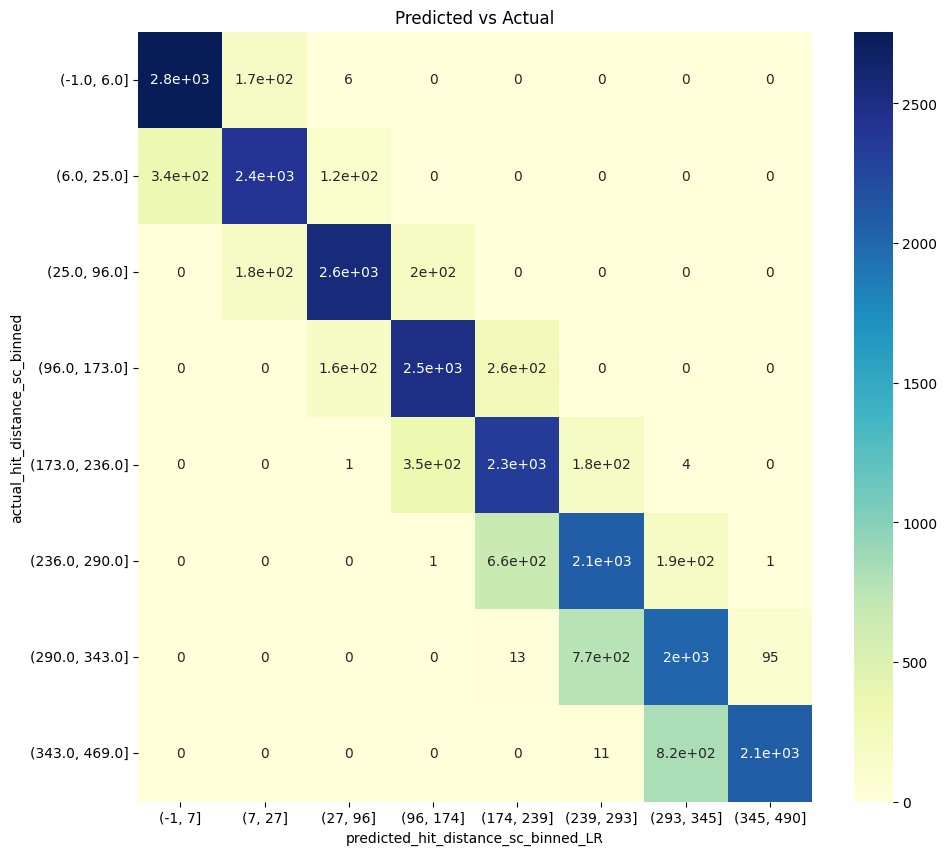

In [31]:
y_valid['actual_hit_distance_sc_binned'] = pd.qcut(y_valid['hit_distance_sc'], q=8, precision=0)
y_valid = y_valid.reset_index()
y_valid = y_valid.reset_index()
y_valid = y_valid.rename(columns={'level_0': 'key'})


df_predicted_LR = pd.DataFrame(predicted_distance, columns=['predicted_hit_distance_sc'])
bins = [-1, 7, 27, 96, 174, 239, 293, 345, 490]
df_predicted_LR['predicted_hit_distance_sc_binned_LR'] = pd.cut(df_predicted_LR['predicted_hit_distance_sc'], bins)
df_predicted__LR = df_predicted_LR.reset_index()
df_predicted__LR = df_predicted__LR.rename(columns={'index': 'key'})
result_2 = pd.merge(y_valid, df_predicted__LR, on="key")
result_2_heatmap = result_2.pivot_table(index='actual_hit_distance_sc_binned', columns='predicted_hit_distance_sc_binned_LR', aggfunc='count')


plt.figure(figsize=(50,10))
plt.subplot(141)
sns.heatmap(result_2_heatmap['hit_distance_sc'],cmap="YlGnBu",annot=True)
plt.title('Predicted vs Actual')
plt.show()


# **TODO**

- over fitting vs under fitting?

- impute

- humidity and temp for eventual drag feature

- Spray vs HAA

- VAA vs LA
